In [2]:
import numpy as np
import torch
import torch.nn.functional as F
import tiktoken
import logging
import json
from time import time
from safetensors import safe_open
from src import FlashSTU
from config import FlashSTUConfig
import torch.nn as nn

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


def get_hankel(seq_len: int, use_hankel_L: bool = False) -> np.ndarray:
    entries = np.arange(1, seq_len + 1, dtype=np.float64)
    i_plus_j = entries[:, None] + entries[None, :]

    if use_hankel_L:
        sgn = (-1.0) ** (i_plus_j - 2.0) + 1.0
        denom = (i_plus_j + 3.0) * (i_plus_j - 1.0) * (i_plus_j + 1.0)
        Z = sgn * (8.0 / denom)
    elif not use_hankel_L:
        Z = 2.0 / (i_plus_j**3 - i_plus_j)
    else:
        raise ValueError("use_hankel_L must be a boolean")

    return Z

def get_spectral_filters(
    seq_len: int, 
    K: int, 
    use_hankel_L: bool = False, 
    device: torch.device = None,
    dtype: torch.dtype = torch.bfloat16,
) -> torch.Tensor:
    assert torch.cuda.is_available(), "CUDA is required."
    Z = get_hankel(seq_len, use_hankel_L)
    sigma, phi = np.linalg.eigh(Z)
    sigma_k, phi_k = sigma[-K:], phi[:, -K:]
    phi_k *= sigma_k ** 0.25
    filters = torch.from_numpy(phi_k)
    return filters.to(device=device, dtype=dtype)

# Load the checkpoint
print("Loading the checkpoint...")
start_time = time()
state_dict = {}
with safe_open(
    "model_19073.safetensors",
    framework="pt",
    device="cuda",
) as f:
    for k in f.keys():
        state_dict[k] = f.get_tensor(k)

print(f"Successfully loaded the checkpoint in {time() - start_time:.2f} seconds")


c:\Users\devan\anaconda3\envs\flashstu\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Unable to import FlashFFTConv: No module named 'flashfftconv'. Falling back to PyTorch implementation.
Unable to import Triton-based MLP: No module named 'liger_kernel'. Falling back to vanilla SwiGLU MLP instead.
Unable to import Triton-based RMSNorm: No module named 'liger_kernel'. Falling back to PyTorch implementation.
Unable to import Triton-based MLP: No module named 'liger_kernel'. Falling back to vanilla SwiGLU MLP instead.
Unable to import Triton-based RMSNorm: No module named 'liger_kernel'. Falling back to PyTorch implementation.
Unable to import Triton-based RMSNorm: No module named 'liger_kernel'. Falling back to PyTorch implementation.
Using device: cuda
Loading the checkpoint...
Successfully loaded the checkpoint in 2.10 seconds


In [65]:
# Set precision for matrix multiplication
torch.set_float32_matmul_precision("high")

# Load model configurations from JSON file
with open("config.json", "r") as file:
    config = json.load(file)

# Extract model configurations
n_embd = config["n_embd"]
n_heads = config["n_heads"]
n_layers = config["n_layers"]
seq_len = config["seq_len"]
window_size = config["window_size"]
vocab_size = config["vocab_size"]
mlp_scale = config["mlp_scale"]
bias = config["bias"]
dropout = config["dropout"]
num_eigh = config["num_eigh"]
use_hankel_L = config["use_hankel_L"]
use_flash_fft = config["use_flash_fft"]
use_approx = config["use_approx"]
use_attn = config["use_attn"]
softcap = config["softcap"]

# Model setup
config = FlashSTUConfig(
    n_embd=n_embd,
    n_heads=n_heads,
    n_layers=n_layers,
    seq_len=seq_len,
    window_size=window_size,
    vocab_size=vocab_size,
    mlp_scale=mlp_scale,
    bias=bias,
    dropout=dropout,
    num_eigh=num_eigh,
    use_hankel_L=use_hankel_L,
    use_flash_fft=use_flash_fft,
    use_approx=use_approx,
    use_attn=use_attn,
    softcap=softcap,
    torch_dtype=getattr(torch, config["torch_dtype"]),
)
phi = get_spectral_filters(seq_len, num_eigh, use_hankel_L, device, torch.float32)
model = FlashSTU(config, phi)

# Load state dictionary into the model
model.load_state_dict(state_dict, strict = True)
model.to(device)
model.eval()

# Prepare tokenizer
tokenizer = tiktoken.get_encoding("o200k_base")

Model Parameter Count: 426.28M



In [4]:
import tqdm
def generate_text(
    model, tokenizer, prompt, num_return_sequences=4, max_length=1024, device="cuda", temperature=1.0, top_k=50
):
    model.eval()
    tokens = torch.tensor([tokenizer.encode(prompt, allowed_special={"<|endoftext|>"})], device=device)
    tokens = tokens.repeat(num_return_sequences, 1)

    sample_rng = torch.Generator(device=device)
    sample_rng.manual_seed(1337)

    eos_token_id = tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"})[0]

    with torch.no_grad():
        for _ in tqdm.tqdm(range(max_length - tokens.size(1))):
            with torch.amp.autocast(device_type="cuda", dtype=torch.bfloat16):
                logits = model(tokens)
                logits = logits[:, -1, :]  # Get logits for the last token

                # Apply temperature scaling if temperature > 0
                if temperature > 0:
                    logits = logits / temperature

            probs = F.softmax(logits, dim=-1)  # Compute probabilities

            # Top-K sampling: set all probabilities outside the top K to 0
            top_k_probs, top_k_indices = torch.topk(probs, top_k, dim=-1)
            ix = torch.multinomial(top_k_probs, 1, generator=sample_rng)
            next_token = torch.gather(top_k_indices, -1, ix)
            tokens = torch.cat((tokens, next_token), dim=1)

            # Break if EOS token is generated
            if (next_token == eos_token_id).any():
                break

    generated_sequences = []
    for i in range(num_return_sequences):
        decoded = tokenizer.decode(tokens[i].tolist())
        generated_sequences.append(decoded)

    return generated_sequences

In [4]:
prompts = [
    "The future of artificial intelligence is",
    # "In the year 2050, the world will",
    # "The most important scientific discovery of the 21st century is",
    # "If I could change one thing about the education system, it would be",
    # "In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.",
]

for prompt in prompts:
    print(f"\nGenerating text for prompt: '{prompt}'\n")
    generated_texts = generate_text(model, tokenizer, prompt, num_return_sequences=1, max_length=50)
    for i, text in enumerate(generated_texts):
        print(f"Sample {i + 1}: {text}\n")



Generating text for prompt: 'The future of artificial intelligence is'



100%|██████████| 44/44 [00:06<00:00,  6.91it/s]

Sample 1: The future of artificial intelligence is also a bit controversial in the political area. The idea of artificial intelligence is actually a part of people who might not have a clear idea of how can we make this technology come to life. People that already have computers can



In [26]:
import copy
stu = copy.deepcopy(model.layers[0].stu)
stu.phi = stu.phi.to(torch.bfloat16)

In [8]:
def exponential_decay_init(size, lam=5.0):
    """
    Samples from an exponential distribution with rate lam, 
    then clips at 1, does (1 - clipped_value),
    and finally multiplies by ±1 with probability 1/2.
    """
    # 1) Sample uniform [0,1], convert to exponential
    u = torch.rand(size)
    x = -1.0 / lam * torch.log(1 - u)  # Exponential(λ = lam)

    # 2) Clip at 1
    x = torch.clamp(x, max=1.0)

    # 3) Subtract from 1 (to be near 1 for small x)
    x = 1.0 - x  # Now we have distribution mostly near 1 for large lam

    # 4) Multiply by ±1 with prob 1/2
    sign = torch.sign(torch.randn(size))
    return x * sign

(array([219., 124.,  60.,  34.,  18.,   8.,   7.,   2.,   2.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.,   2.,   2.,   0.,   5.,
         11.,  17.,  30.,  76., 135., 245.]),
 array([-9.99895751e-01, -9.59897876e-01, -9.19899940e-01, -8.79902065e-01,
        -8.39904130e-01, -7.99906254e-01, -7.59908319e-01, -7.19910443e-01,
        -6.79912508e-01, -6.39914632e-01, -5.99916697e-01, -5.59918821e-01,
        -5.19920886e-01, -4.79923010e-01, -4.39925104e-01, -3.99927199e-01,
        -3.59929293e-01, -3.19931388e-01, -2.79933482e-01, -2.39935577e-01,
        -1.99937671e-01, -1.59939766e-01, -1.19941860e-01, -7.99439549e-02,
        -3.99460495e-02,  5.18560410e-05,  4.00497615e-02,  8.00476670e-02,
         1.20045573e-01,  1.60043478e-01,  2.00041384e-01,  2.40039289e-01,
         2.80037194e-01,  3.20035100e-01,  3.60033

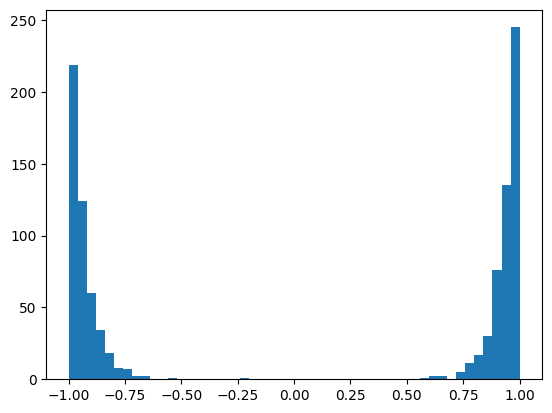

In [7]:
import matplotlib.pyplot as plt
plt.hist(exponential_decay_init(1000, lam = 15), bins =50)

In [9]:
import torch

def compute_ar_x_preds(w: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
    """
    Compute the auto-regressive component of a spectral SSM (PyTorch version),
    allowing for a batch dimension in `x`.

    Args:
        w: A tensor of shape [d_out, d_in, k].
        x: A tensor of shape [batch_size, l, d_in].

    Returns:
        A tensor of shape [batch_size, l, d_out].
    """
    d_out, d_in, k = w.shape
    b, l, d_in_x = x.shape
    assert d_in == d_in_x, (
        f"Dimension mismatch: w.shape={w.shape}, x.shape={x.shape}"
    )

    o = torch.einsum("oik,bli->bklo", w, x)

    for i in range(k):
        # shape: [b, l, d_out]
        o[:, i] = torch.roll(o[:, i], shifts=i, dims=1)

    m = torch.triu(torch.ones(k, l, dtype=o.dtype, device=o.device))  # [k, l]
    # shape: [k, l, 1] -> then repeat along d_out
    m = m.unsqueeze(-1).repeat(1, 1, d_out)  # [k, l, d_out]

    ar_x_preds = torch.sum(o * m, dim=1)  # now shape is [b, l, d_out]

    return ar_x_preds


In [11]:
class LDS(nn.Module):
    def __init__(self, state_dim, input_dim, output_dim, kx=5):
        super(LDS, self).__init__()
        self.state_dim = state_dim
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.kx = kx
        self.h0 = nn.Parameter(torch.randn(state_dim))
        # init_A = torch.randn(state_dim)
        # self.A = nn.Parameter(init_A / torch.max(torch.abs(init_A)))

        # self.A = nn.Parameter((torch.rand(state_dim) * 0.2 + 0.8) * torch.sign(torch.randn(state_dim)))
        self.A = nn.Parameter(exponential_decay_init([state_dim], lam = 15))
        self.B = nn.Parameter(torch.randn(input_dim, state_dim) / input_dim)
        self.C = nn.Parameter(torch.randn(state_dim, output_dim) / state_dim)
        self.M = nn.Parameter(torch.randn(output_dim, input_dim, kx) / (output_dim))

    def forward(self, inputs):
        device = inputs.device
        bsz, seq_len, _ = inputs.shape
        h_t = self.h0.expand(bsz, self.state_dim).to(device)
        A = self.A.flatten()
        all_h_t = []
        for t in range(seq_len):
            u_t = inputs[:, t, :]
            h_t = A * h_t + (u_t @ self.B)
            all_h_t.append(h_t.unsqueeze(1))
        all_h_t = torch.cat(all_h_t, dim=1)
        lds_out = torch.matmul(all_h_t, self.C)

        ar = compute_ar_x_preds(self.M, inputs)
        return lds_out + ar

    def compute_loss(self, inputs, targets):
        mse_loss = nn.MSELoss()
        outputs = self(inputs)
        return mse_loss(outputs, targets)

In [20]:
import math
class LDS_LR(nn.Module):
    def __init__(self, state_dim, input_dim, output_dim, kx=5, rank = 50):
        super(LDS_LR, self).__init__()
        self.state_dim = state_dim
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.kx = kx
        self.h0 = nn.Parameter(torch.randn(state_dim))
        # init_A = torch.randn(state_dim)
        # self.A = nn.Parameter(init_A / torch.max(torch.abs(init_A)))

        self.A = nn.Parameter(exponential_decay_init([state_dim], lam = 15))
        self.B1 = nn.Parameter(torch.randn(input_dim, rank) / (input_dim))
        self.B2 = nn.Parameter(torch.randn(rank, state_dim) / (rank))
        self.C1 = nn.Parameter(torch.randn(state_dim, rank) / (state_dim))
        self.C2 = nn.Parameter(torch.randn(rank, output_dim) / (rank))
        self.M = nn.Parameter(torch.randn(output_dim, input_dim, kx) / (output_dim))


        # self.M1 = nn.Parameter(torch.randn(rank, input_dim, kx) / math.sqrt(output_dim))
        # self.M2 = nn.Parameter(torch.randn(output_dim, rank, kx) / math.sqrt(output_dim))

    def forward(self, inputs):
        device = inputs.devic
        bsz, seq_len, _ = inputs.shape
        h_t = self.h0.expand(bsz, self.state_dim).to(device)
        A = self.A.flatten()
        all_h_t = []

        lds_in = torch.matmul(inputs, self.B1)
        lds_in = torch.matmul(lds_in, self.B2)

        for t in range(seq_len):
            h_t = A * h_t + lds_in[:, t, :]
            all_h_t.append(h_t.unsqueeze(1))
        all_h_t = torch.cat(all_h_t, dim=1)
 
        lds_out = torch.matmul(all_h_t, self.C1)
        lds_out = torch.matmul(lds_out, self.C2)

        ar = compute_ar_x_preds(self.M, inputs)

        # ar = compute_ar_x_preds(self.M1, inputs)
        # ar = comspute_ar_x_preds(self.M2, ar)
        
        return lds_out + ar

    def compute_loss(self, inputs, targets):
        mse_loss = nn.MSELoss()
        outputs = self(inputs)
        return mse_loss(outputs, targets)


In [37]:
def custom_loss(output, target):
    """
    Custom MSE loss function with a 40x multiplier for the [:,:,491] coordinate.
    
    Args:
        output (torch.Tensor): Predicted output from the model.
        target (torch.Tensor): Ground truth values.

    Returns:
        torch.Tensor: Computed loss value.
    """
    # Standard MSE loss for all elements
    mse_loss = (output - target) ** 2

    # Apply a 40x multiplier to the [:, :, 491] coordinate
    mse_loss[:, :, 491] *= 40

    # Compute the mean loss
    return mse_loss.mean()

In [ ]:
state_dim = 1000 #@param
lds = LDS(state_dim, 768, 768, kx=5).to(device)
optimizer = torch.optim.Adam(lds.parameters(), lr=0.002)
lds_epochs = 200
lds_loss_values = []

for epoch in range(lds_epochs):
    inputs = torch.randn(10, 4096, 768).to(device).to(torch.bfloat16)
    stu_outputs = stu(inputs).to(device)

    optimizer.zero_grad()
    output = lds(inputs.to(stu_outputs.dtype))

    # Use the custom loss function
    loss = custom_loss(output, stu_outputs)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(lds.parameters(), max_norm=1)
    lds_loss_values.append(loss.item())
    optimizer.step()

    with torch.no_grad():
        lds.A.data.clamp_(max=1, min=-1)

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')


NameError: name 'stu' is not defined

In [79]:
#remarkably, the approximation gets better and better as state_dim increases from  20 to ~500 (i.e 500 is 8x better than 50)
state_dim = 10000 #@param
lds = LDS(state_dim, 768, 768, kx = 10).to(device)
optimizer = torch.optim.Adam(lds.parameters(), lr = 0.0002)
lds_epochs = 200
lds_loss_values = []

for epoch in range(lds_epochs):
    inputs = torch.randn(10, 4096, 768).to(device).to(torch.bfloat16)
    stu_outputs = stu(inputs).to(device)

    optimizer.zero_grad()
    loss = lds.compute_loss(inputs.to(stu_outputs.dtype), stu_outputs)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(lds.parameters(), max_norm=1)
    lds_loss_values.append(loss.item())
    optimizer.step()

    with torch.no_grad():
        lds.A.data.clamp_(max=1, min = -1)

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}') #Epoch 2000, Loss: 0.00030023115687072277 for normal LDS and  state dim  10000
        #Epoch 2000, Loss: 0.001 for normal LDS and  state dim  1000
        #0.0007 for 2000 epochs on LDS with 5 autoregressive heads

        #with improved init we reach 0.00029 in 300 epochs at kx = 5
        #with improved init we reach 0.00027 in 300 epochs (range 0.7 - 1) at kx =5
        #with improved init we reached 0.00024 in 300 with range (0.8 - 1) at kx = 5
        #but worse perf for (0.9 - 1) at kx = 10
        #0.00020 with lam = 15

        #interestingly, it gets worse after a few hundred epochs

Epoch 0, Loss: 0.11160150170326233


KeyboardInterrupt: 

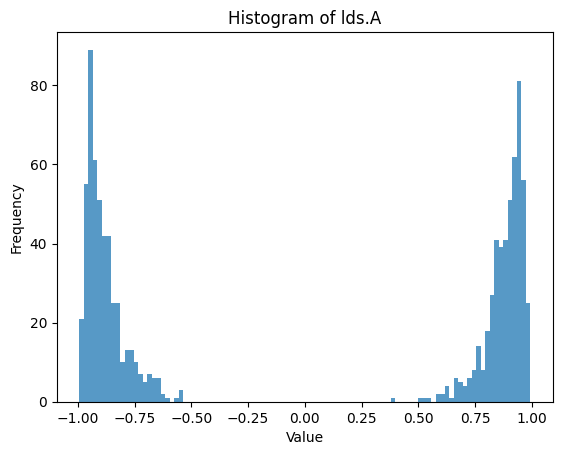

In [42]:
import matplotlib.pyplot as plt

# Convert lds.A to a numpy array and plot the histogram
A_data = lds.A.data.cpu().numpy()
plt.hist(A_data, bins=100, alpha=0.75)
plt.title('Histogram of lds.A')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

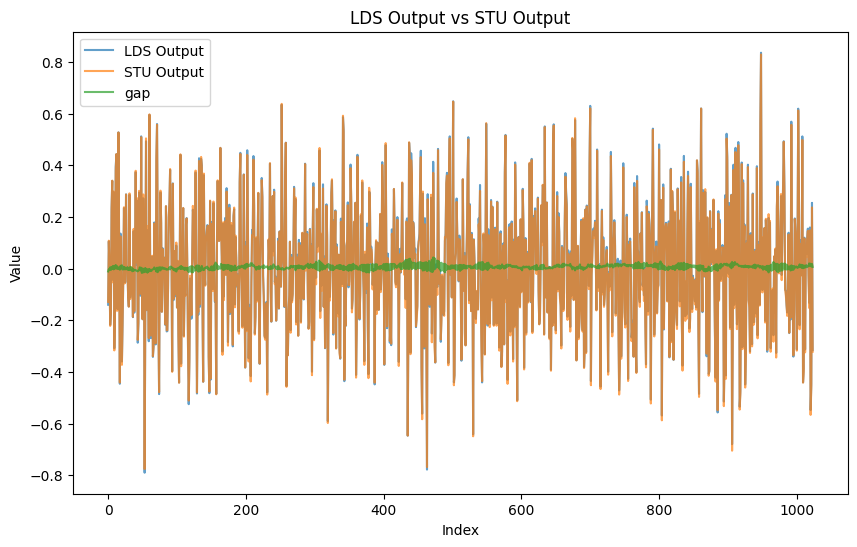

In [76]:
import matplotlib.pyplot as plt
#comparing trajectory of first digit
# Generate random input
input_data = torch.randn(1, 1024, 768).to(device).to(torch.bfloat16)

# Compute outputs from lds and stu
lds_output = lds(input_data.to(torch.float))
stu_output = stu(input_data)

# Convert outputs to numpy arrays for plotting
lds_output_np = lds_output[:,:,4].detach().cpu().numpy().flatten()
stu_output_np = stu_output[:,:,4].detach().cpu().numpy().flatten()

gap = lds_output_np - stu_output_np

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(lds_output_np, label='LDS Output', alpha=0.7)
plt.plot(stu_output_np, label='STU Output', alpha=0.7)
plt.plot(gap, label='gap', alpha=0.7)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('LDS Output vs STU Output')
plt.legend()
plt.show()

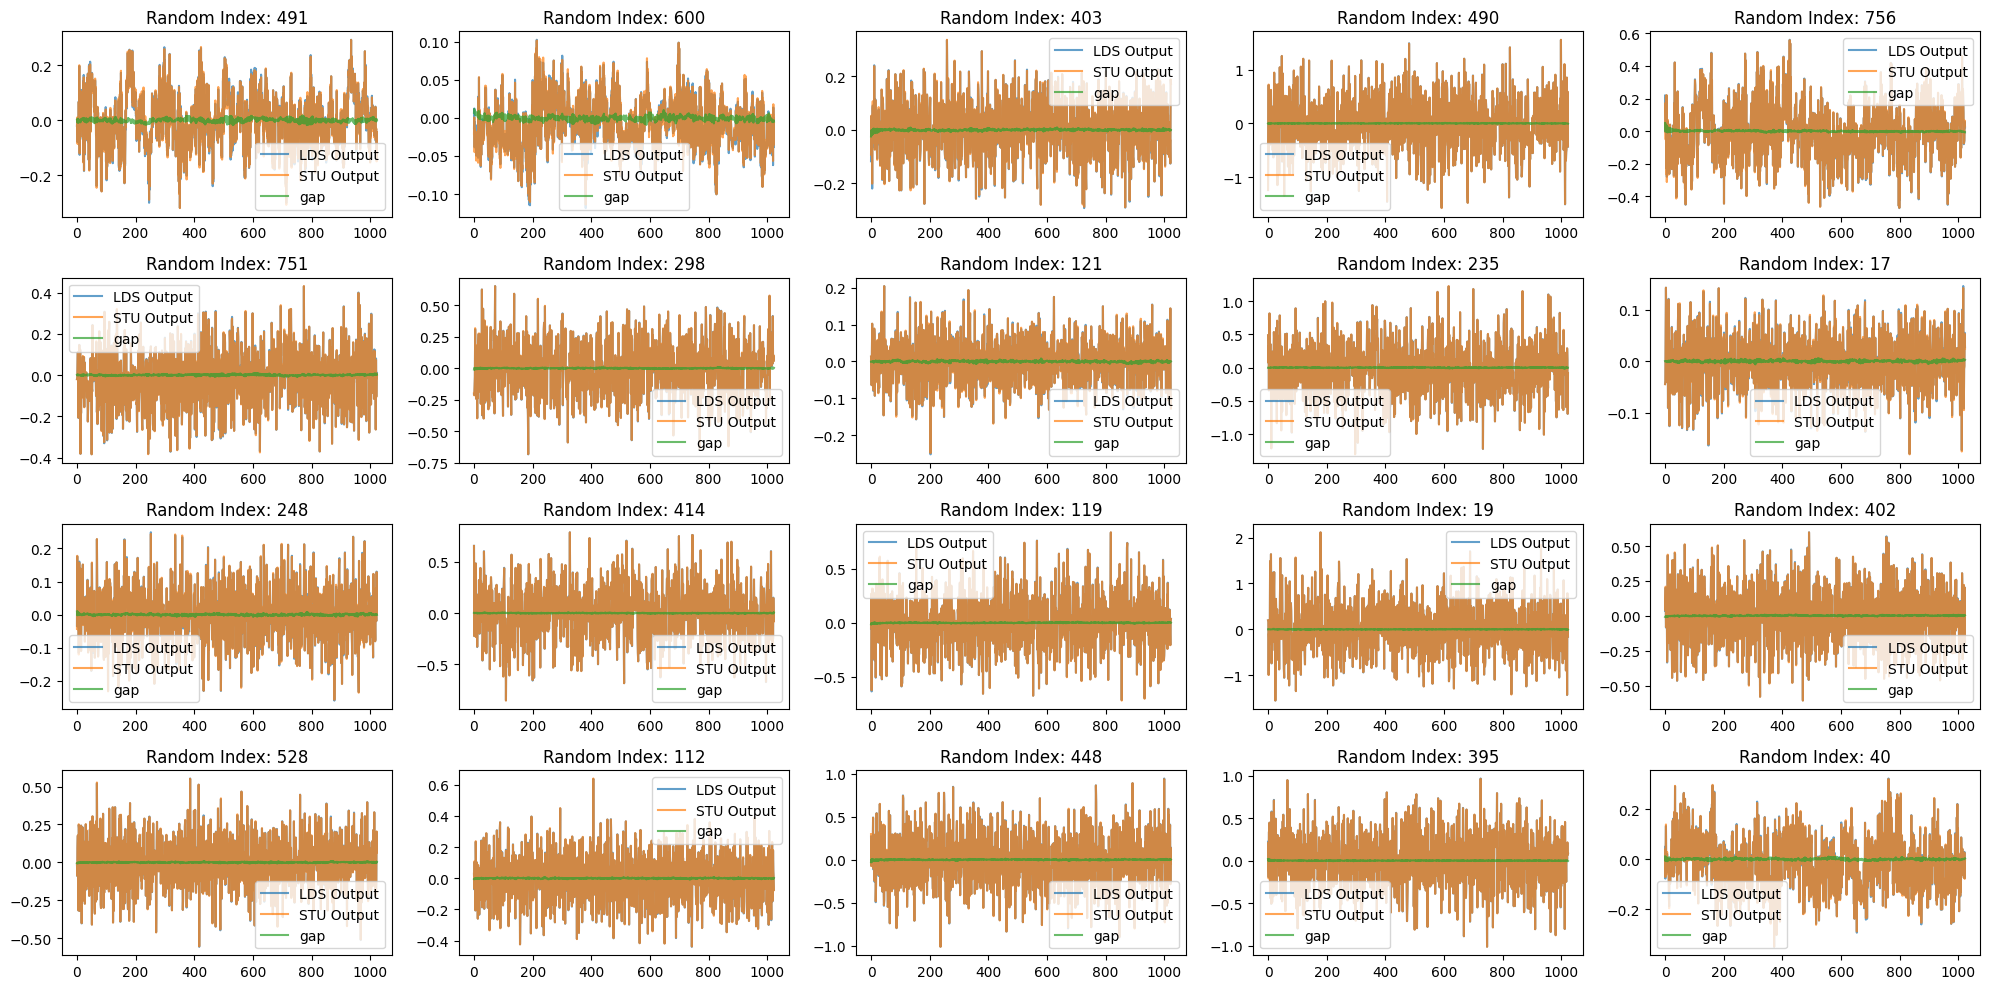

In [63]:
import matplotlib.pyplot as plt

# Generate random input
input_data = torch.randn(1, 1024, 768).to(device).to(torch.bfloat16)

# Compute outputs from lds and stu
lds_output = lds_model(input_data.to(torch.float))
stu_output = stu(input_data)

# Convert outputs to numpy arrays for plotting
lds_output_np = lds_output.detach().cpu().numpy()
stu_output_np = stu_output.detach().cpu().numpy()

# Plot 20 random values for [:,:,4] in the outputs
fig, axes = plt.subplots(4, 5, figsize=(20, 10))
axes = axes.flatten()

for i in range(20):
    if i == 0:
        random_index = 491 #source of much of the variance
    elif i == 1:
        random_index = 600
    else:
        random_index = np.random.randint(0, lds_output_np.shape[2])
    lds_value = lds_output_np[:, :, random_index].flatten()
    stu_value = stu_output_np[:, :, random_index].flatten()

    gap = lds_value - stu_value
    
    axes[i].plot(lds_value, label='LDS Output', alpha=0.7)
    axes[i].plot(stu_value, label='STU Output', alpha=0.7)
    axes[i].plot(gap, label='gap', alpha=0.7)
    axes[i].set_title(f'Random Index: {random_index}')
    axes[i].legend()

plt.tight_layout()
plt.show()

In [ ]:
# torch.save(lds.state_dict(), "./lds_layer_new_2cap_0.pt")

In [61]:
# Load the model and optimizer
checkpoint = torch.load("./lds_trained/9344_0_10000_best_lds_model_and_optimizer.pt")
lds_model = LDS(state_dim=10000, input_dim=768, output_dim=768, kx=10)
lds_model.load_state_dict(checkpoint['lds_state_dict'], strict =  True)
lds_model = lds_model.to(device)

C:\Users\devan\AppData\Local\Temp\ipykernel_36004\2434354370.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("./lds_trained/9344_0_10000_best_lds

In [63]:
checkpoint['lds_state_dict']["M"].shape

torch.Size([768, 768, 10])

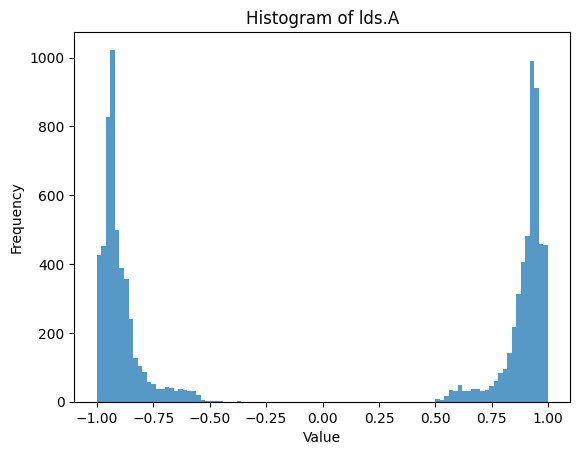

In [54]:
import matplotlib.pyplot as plt
A_data = lds_model.A.data.cpu().numpy()
plt.hist(A_data, bins=100, alpha=0.75)
plt.title('Histogram of lds.A')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [46]:
percent_over_0_9 = np.sum(A_data > 0.9) / len(A_data) * 100
print(f"Percentage of values over 0.9: {percent_over_0_9:.2f}%")

Percentage of values over 0.9: 31.32%


In [47]:
from dataloader import DataLoader

val_loader = DataLoader(
    bsz=1,
    seq_len=seq_len, 
    dataset='./fineweb-edu', 
    split="val", 
    main_process=True,
)

2025-01-17 14:35:00,986 - INFO - Found 1 shards for split val


In [48]:
from torch.amp import autocast
from torch.nn import CrossEntropyLoss

def evaluate(model, val_steps = 5):
    loss_fn = CrossEntropyLoss()
    val_loss = 0.0
    torch_dtype = getattr(torch, 'bfloat16')
    # val_steps = 5 # Arbitrarily set to reduce long evaluations, >20 typically used
    model.eval()
    val_loader.reset()
    with torch.no_grad():
        for i, batch in zip(range(val_steps), val_loader, strict=False):
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)
            if torch_dtype != torch.float32:
                with autocast(device_type=device.type, dtype=torch_dtype, cache_enabled=True):
                    preds = model(inputs)
            else:
                preds = model(inputs)

            loss = loss_fn(preds.flatten(0, 1), targets.flatten(0, 1))
            loss = loss / val_steps
            val_loss += loss.detach().float()
    return(val_loss)

In [ ]:
model

In [66]:
evaluate(model,20)

tensor(3.5293, device='cuda:0')

In [17]:
stu_save = copy.deepcopy(model.layers[0].stu)

In [57]:
# model.layers[0].stu = lds.to(device)
model.layers[0].stu = lds_model.to(device)
evaluate(model, 20)


tensor(3.9912, device='cuda:0')

In [24]:
class NoisySTULayer(nn.Module):
    def __init__(self, stu_layer, noise_std=0.01):
        super(NoisySTULayer, self).__init__()
        self.stu_layer = stu_layer
        self.noise_std = noise_std

    def forward(self, inputs):
        stu_output = self.stu_layer(inputs)
        noise = torch.randn_like(stu_output) * self.noise_std
        return stu_output + noise


noisy_stu_layer = NoisySTULayer(stu, noise_std=0.1).to(device)

# Pass some input through the new layer
random_input = torch.randn(1, 1024, 768).to(device).to(torch.bfloat16)
output = noisy_stu_layer(random_input.to(torch.bfloat16))
print(output)

tensor([[[-0.0974, -0.1358, -0.1509,  ..., -0.1194, -0.0366, -0.3268],
         [-0.0996, -0.0371, -0.0337,  ...,  0.2677,  0.7074, -0.0070],
         [ 0.2556,  0.0296, -0.2013,  ..., -0.0498, -0.1433, -0.1131],
         ...,
         [ 0.1120,  0.1537, -0.0834,  ...,  0.1249,  0.0119, -0.0844],
         [ 0.1779,  0.1942,  0.2059,  ...,  0.1174, -0.0488,  0.1695],
         [-0.1423,  0.0500, -0.1740,  ..., -0.0164, -0.1261,  0.2526]]],
       device='cuda:0', grad_fn=<AddBackward0>)


In [25]:

model.layers[0].stu = noisy_stu_layer
evaluate(model)

tensor(3.6719, device='cuda:0')

In [73]:
class MixedSTU(nn.Module):
    def __init__(self, stu_layer, lds_model, idx):
        super(MixedSTU, self).__init__()
        self.stu = stu_layer
        self.lds = lds_model
        self.idx = idx

    def forward(self, inputs):
        output = self.lds(inputs)
        output[:,:,self.idx] = self.stu(inputs)[:,:,self.idx]
        return output


In [74]:
model.layers[0].stu = MixedSTU(stu, lds_model, 600) #a single index contributes to half the error 
evaluate(model)

tensor(3.8398, device='cuda:0')

x = 0, Loss: 4.00390625
x = 20, Loss: 4.00390625
x = 40, Loss: 3.9765625
x = 60, Loss: 3.984375
x = 80, Loss: 3.97265625
x = 100, Loss: 3.96875
x = 120, Loss: 3.96875
x = 140, Loss: 3.97265625
x = 160, Loss: 3.96484375
x = 180, Loss: 3.9609375
x = 200, Loss: 3.9609375
x = 220, Loss: 3.96875
x = 240, Loss: 3.93359375
x = 260, Loss: 3.87890625
x = 280, Loss: 3.875
x = 300, Loss: 3.875
x = 320, Loss: 3.875
x = 340, Loss: 3.85546875
x = 360, Loss: 3.85546875
x = 380, Loss: 3.87109375
x = 400, Loss: 3.86328125
x = 420, Loss: 3.87109375
x = 440, Loss: 3.8515625
x = 460, Loss: 3.83203125
x = 480, Loss: 3.8359375
x = 500, Loss: 3.83203125
x = 520, Loss: 3.79296875
x = 540, Loss: 3.7890625
x = 560, Loss: 3.76953125
x = 580, Loss: 3.765625
x = 600, Loss: 3.78515625
x = 620, Loss: 3.578125
x = 640, Loss: 3.56640625
x = 660, Loss: 3.55859375
x = 680, Loss: 3.54296875
x = 700, Loss: 3.52734375
x = 720, Loss: 3.51953125
x = 740, Loss: 3.51953125
x = 760, Loss: 3.515625


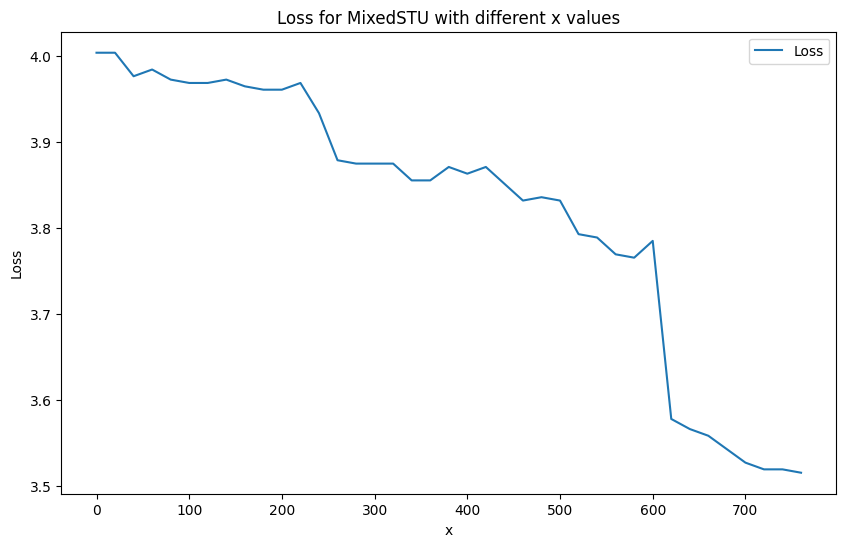

In [62]:
import matplotlib.pyplot as plt

# Initialize an empty list to store the losses
losses = []

# Iterate over the range of x values
for x in range(0, 761, 20):
    model.layers[0].stu = MixedSTU(stu, lds_model, x).to(device)
    loss = evaluate(model)
    losses.append(loss.item())
    print(f"x = {x}, Loss: {loss.item()}")

# Plot the losses
plt.figure(figsize=(10, 6))
plt.plot(range(0, 761, 20), losses, label='Loss')
plt.xlabel('x')
plt.ylabel('Loss')
plt.title('Loss for MixedSTU with different x values')
plt.legend()
plt.show()

In [62]:
import torch.nn.functional as F

# Generate random input
random_input = torch.randn(1, 1024, 768).to(device).to(torch.bfloat16)

# Compute outputs from stu and lds_model
stu.phi = stu.phi.to(torch.bfloat16)
stu_output = stu(random_input)
lds_model_output = lds_model(random_input.to(torch.float))

# Extract coordinate 600
stu_coord_600 = stu_output[:, :, 600]
lds_model_coord_600 = lds_model_output[:, :, 600]

# Compute MSE
mse = F.mse_loss(stu_coord_600, lds_model_coord_600)

# Compute MAE
mae = F.l1_loss(stu_coord_600, lds_model_coord_600)

# Compute MSE/MAE from the mean on the coordinate
mean_coord_600 = torch.mean(stu_coord_600)
mse_from_mean = F.mse_loss(stu_coord_600, mean_coord_600.expand_as(stu_coord_600))
mae_from_mean = F.l1_loss(stu_coord_600, mean_coord_600.expand_as(stu_coord_600))

print(f"MSE on coordinate 600: {mse.item()}")
print(f"MAE on coordinate 600: {mae.item()}")
print(f"MSE from mean on coordinate 600: {mse_from_mean.item()}")
print(f"MAE from mean on coordinate 600: {mae_from_mean.item()}")

# Compute MAE of the stu output
mae_stu_output =stu_coord_600.abs().mean()
print(f"MAE of the abs of stu output: {mae_stu_output.item()}")

MSE on coordinate 600: 8.384891771129332e-06
MAE on coordinate 600: 0.002298349281772971
MSE from mean on coordinate 600: 0.0014972406206652522
MAE from mean on coordinate 600: 0.03053773194551468
MAE of the abs of stu output: 0.03237937390804291


In [81]:
stu_output[:,:,601]

tensor([[-0.2242,  0.5497,  0.5006,  ...,  0.2189, -0.4040,  0.1989]],
       device='cuda:0', grad_fn=<SelectBackward0>)

In [69]:
class MixedSTU2(nn.Module):
    def __init__(self, stu_layer, lds_model, idx, idx2):
        super(MixedSTU2, self).__init__()
        self.stu = stu_layer
        self.lds = lds_model
        self.idx = idx
        self.idx2 = idx2

    def forward(self, inputs):
        output = self.lds(inputs)
        output[:,:,self.idx:self.idx2] = self.stu(inputs)[:,:,self.idx:self.idx2]
        return output
model.layers[0].stu = MixedSTU2(stu, lds_model, 600,601) 
evaluate(model)

tensor(3.8398, device='cuda:0')

In [87]:
import torch.nn as nn

# Generate random input
random_input = torch.randn(1, 1024, 768).to(device).to(torch.bfloat16)

# Compute outputs from stu and lds_model
stu.phi = stu.phi.to(torch.bfloat16)
stu_output = stu(random_input)
lds_model_output = lds_model(random_input.to(torch.float))

# Compute MSE loss
mse_loss_fn = nn.MSELoss()
mse_loss = mse_loss_fn(stu_output, lds_model_output)

print(f"MSE Loss: {mse_loss.item()}")

MSE Loss: 1.0572446626611054e-05


In [27]:
import torch.nn as nn

# Generate random input
random_input = torch.randn(1, 1024, 768).to(device).to(torch.bfloat16)

# Compute outputs from stu and lds_model
stu.phi = stu.phi.to(torch.bfloat16)
stu_output = stu(random_input)
output = noisy_stu_layer(random_input)

# Compute MSE loss
mse_loss_fn = nn.MSELoss()
mse_loss = mse_loss_fn(stu_output, output)

print(f"MSE Loss: {mse_loss.item()}")

MSE Loss: 0.009989653714001179


In [28]:
class NoisySTULayer(nn.Module):
    def __init__(self, stu_layer, noise_std=0.01, noise_index=0):
        super(NoisySTULayer, self).__init__()
        self.stu_layer = stu_layer
        self.noise_std = noise_std
        self.noise_index = noise_index

    def forward(self, inputs):
        stu_output = self.stu_layer(inputs)
        noise = torch.zeros_like(stu_output)
        noise[:, :, self.noise_index] = torch.randn(stu_output.size(0), stu_output.size(1), device=stu_output.device) * self.noise_std
        return stu_output + noise

In [32]:
import matplotlib.pyplot as plt

# Initialize an empty list to store the losses
losses = []

# Iterate over each index and compute the loss
for index in range(768):
    noisy_stu_layer = NoisySTULayer(stu, noise_std=1, noise_index=index).to(device)
    model.layers[0].stu = noisy_stu_layer
    loss = evaluate(model)
    losses.append(loss.item() - 3.5156)
    print(f"Index {index}, Loss: {loss.item()}")

# Plot the losses
plt.figure(figsize=(10, 6))
plt.plot(range(768), losses, label='Loss with noise_std=0.1')
plt.xlabel('Index')
plt.ylabel('Loss')
plt.title('Loss with noise_std=0.1 on Each Index')
plt.legend()
plt.show()

Index 0, Loss: 3.52734375
Index 1, Loss: 3.53515625
Index 2, Loss: 3.53125
Index 3, Loss: 3.5234375
Index 4, Loss: 3.52734375
Index 5, Loss: 3.52734375
Index 6, Loss: 3.56640625
Index 7, Loss: 3.52734375
Index 8, Loss: 3.52734375
Index 9, Loss: 3.52734375
Index 10, Loss: 3.52734375
Index 11, Loss: 3.52734375
Index 12, Loss: 3.52734375
Index 13, Loss: 3.52734375
Index 14, Loss: 3.5234375
Index 15, Loss: 3.52734375
Index 16, Loss: 3.52734375
Index 17, Loss: 3.5234375
Index 18, Loss: 3.5390625
Index 19, Loss: 3.52734375
Index 20, Loss: 3.5703125
Index 21, Loss: 3.52734375
Index 22, Loss: 3.52734375
Index 23, Loss: 3.5234375
Index 24, Loss: 3.52734375
Index 25, Loss: 3.52734375
Index 26, Loss: 3.52734375
Index 27, Loss: 3.52734375
Index 28, Loss: 3.5390625
Index 29, Loss: 3.55078125
Index 30, Loss: 3.52734375
Index 31, Loss: 3.5234375
Index 32, Loss: 3.53125
Index 33, Loss: 3.52734375
Index 34, Loss: 3.5234375
Index 35, Loss: 3.52734375
Index 36, Loss: 3.53125
Index 37, Loss: 3.5234375
Ind

KeyboardInterrupt: 

In [34]:
random_input = torch.randn(1, 1024, 768).to(device).to(torch.bfloat16)

# Compute outputs from stu and lds_model
stu.phi = stu.phi.to(torch.bfloat16)
stu_output = stu(random_input)
lds_model_output = lds_model(random_input.to(torch.float))

# Compute the absolute differences
differences = torch.abs(stu_output - lds_model_output)

# Find the 10 indices with the largest differences
top_indices = torch.topk(differences.mean(dim=(0, 1)), 20).indices.cpu().numpy()

# Initialize an empty list to store the losses
losses = []

# Iterate over each top index and compute the loss
for index in top_indices:
    noisy_stu_layer = NoisySTULayer(stu, noise_std=1, noise_index=index).to(device)
    model.layers[0].stu = noisy_stu_layer
    loss = evaluate(model)
    losses.append(loss.item())
    print(f"Index {index}, Loss: {loss.item()}")

Index 656, Loss: 3.75
Index 76, Loss: 3.578125
Index 491, Loss: 4.66796875
Index 310, Loss: 3.53515625
Index 189, Loss: 3.55078125
Index 598, Loss: 3.53125
Index 700, Loss: 3.52734375
Index 300, Loss: 3.5234375
Index 45, Loss: 3.58984375
Index 673, Loss: 3.546875
Index 732, Loss: 3.5625
Index 208, Loss: 3.52734375
Index 93, Loss: 3.52734375
Index 388, Loss: 3.52734375
Index 611, Loss: 3.52734375
Index 550, Loss: 3.52734375
Index 225, Loss: 3.57421875
Index 377, Loss: 3.52734375
Index 282, Loss: 3.54296875
Index 296, Loss: 3.5234375


Index 0, Loss: 3.9921875
Index 1, Loss: 3.9921875
Index 2, Loss: 3.9921875
Index 3, Loss: 3.98828125
Index 4, Loss: 3.9921875
Index 5, Loss: 3.9921875
Index 6, Loss: 3.98828125
Index 7, Loss: 3.9921875
Index 8, Loss: 3.98828125
Index 9, Loss: 3.9921875
Index 10, Loss: 3.98828125
Index 11, Loss: 3.9921875
Index 12, Loss: 3.9921875
Index 13, Loss: 3.9921875
Index 14, Loss: 3.98828125
Index 15, Loss: 3.9921875
Index 16, Loss: 3.9921875
Index 17, Loss: 3.9921875
Index 18, Loss: 3.9921875
Index 19, Loss: 3.9921875
Index 20, Loss: 3.984375
Index 21, Loss: 3.98828125
Index 22, Loss: 3.9921875
Index 23, Loss: 3.9921875
Index 24, Loss: 3.98828125
Index 25, Loss: 3.9921875
Index 26, Loss: 3.9921875
Index 27, Loss: 3.9921875
Index 28, Loss: 3.98828125
Index 29, Loss: 3.9921875
Index 30, Loss: 3.9921875
Index 31, Loss: 3.9921875
Index 32, Loss: 3.97265625
Index 33, Loss: 3.98828125
Index 34, Loss: 3.9921875
Index 35, Loss: 3.9921875
Index 36, Loss: 3.9921875
Index 37, Loss: 3.9921875
Index 38, Los

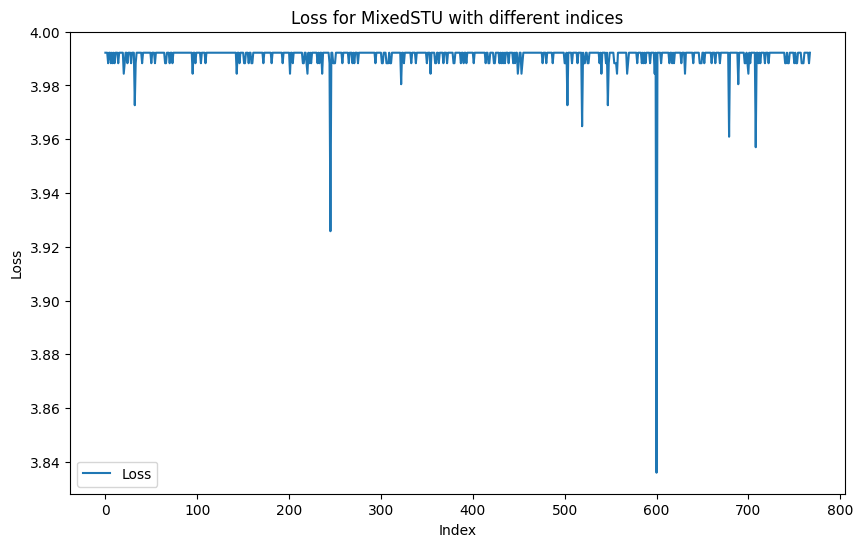

In [27]:

import matplotlib.pyplot as plt

class MixedSTU(nn.Module):
    def __init__(self, stu_layer, lds_model, idx):
        super(MixedSTU, self).__init__()
        self.stu = stu_layer
        self.lds = lds_model
        self.idx = idx

    def forward(self, inputs):
        output = self.lds(inputs)
        output[:,:,self.idx] = self.stu(inputs)[:,:,self.idx]
        return output

# Initialize an empty list to store the losses
losses = []

# Iterate over the range of indices
for idx in range(768):
    model.layers[0].stu = MixedSTU(stu, lds_model, idx).to(device)
    loss = evaluate(model)
    losses.append(loss.item())
    print(f"Index {idx}, Loss: {loss.item()}")

# Plot the losses
plt.figure(figsize=(10, 6))
plt.plot(range(768), losses, label='Loss')
plt.xlabel('Index')
plt.ylabel('Loss')
plt.title('Loss for MixedSTU with different indices')
plt.legend()
plt.show()

In [29]:
losses

[3.9921875,
 3.9921875,
 3.9921875,
 3.98828125,
 3.9921875,
 3.9921875,
 3.98828125,
 3.9921875,
 3.98828125,
 3.9921875,
 3.98828125,
 3.9921875,
 3.9921875,
 3.9921875,
 3.98828125,
 3.9921875,
 3.9921875,
 3.9921875,
 3.9921875,
 3.9921875,
 3.984375,
 3.98828125,
 3.9921875,
 3.9921875,
 3.98828125,
 3.9921875,
 3.9921875,
 3.9921875,
 3.98828125,
 3.9921875,
 3.9921875,
 3.9921875,
 3.97265625,
 3.98828125,
 3.9921875,
 3.9921875,
 3.9921875,
 3.9921875,
 3.9921875,
 3.9921875,
 3.98828125,
 3.9921875,
 3.9921875,
 3.9921875,
 3.9921875,
 3.9921875,
 3.9921875,
 3.9921875,
 3.9921875,
 3.9921875,
 3.98828125,
 3.9921875,
 3.9921875,
 3.9921875,
 3.98828125,
 3.9921875,
 3.9921875,
 3.9921875,
 3.9921875,
 3.9921875,
 3.9921875,
 3.9921875,
 3.9921875,
 3.9921875,
 3.9921875,
 3.98828125,
 3.98828125,
 3.9921875,
 3.9921875,
 3.9921875,
 3.98828125,
 3.9921875,
 3.9921875,
 3.98828125,
 3.9921875,
 3.9921875,
 3.9921875,
 3.9921875,
 3.9921875,
 3.9921875,
 3.9921875,
 3.9921875,


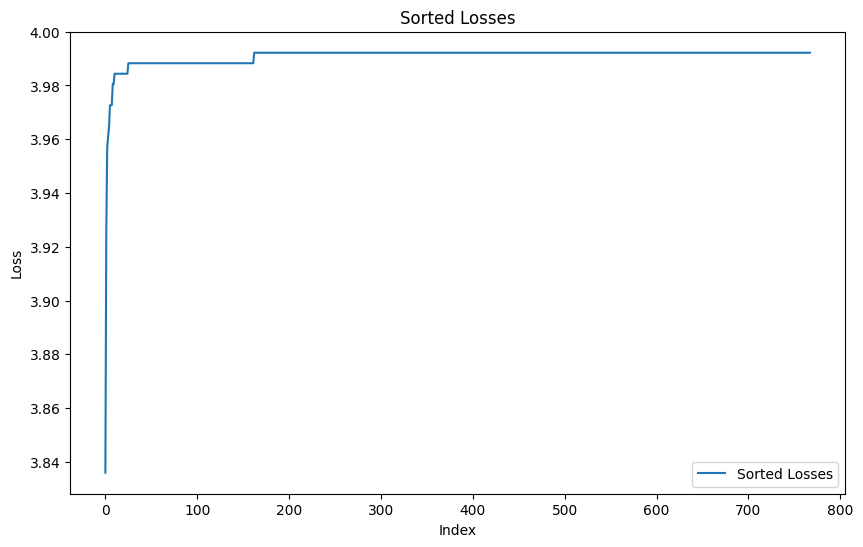

Top 20 index-value pairs:
Index: 600, Loss: 3.8359375
Index: 245, Loss: 3.92578125
Index: 708, Loss: 3.95703125
Index: 679, Loss: 3.9609375
Index: 519, Loss: 3.96484375
Index: 32, Loss: 3.97265625
Index: 503, Loss: 3.97265625
Index: 547, Loss: 3.97265625
Index: 322, Loss: 3.98046875
Index: 689, Loss: 3.98046875
Index: 20, Loss: 3.984375
Index: 95, Loss: 3.984375
Index: 143, Loss: 3.984375
Index: 201, Loss: 3.984375
Index: 220, Loss: 3.984375
Index: 236, Loss: 3.984375
Index: 354, Loss: 3.984375
Index: 449, Loss: 3.984375
Index: 453, Loss: 3.984375
Index: 540, Loss: 3.984375


In [30]:
import matplotlib.pyplot as plt

# Turn losses into a tuple of index and value
losses_tuple = [(index, value) for index, value in enumerate(losses)]

# Sort by value from low to high
sorted_losses = sorted(losses_tuple, key=lambda x: x[1])

# Extract sorted values for plotting
sorted_values = [value for index, value in sorted_losses]

# Plot the sorted values
plt.figure(figsize=(10, 6))
plt.plot(sorted_values, label='Sorted Losses')
plt.xlabel('Index')
plt.ylabel('Loss')
plt.title('Sorted Losses')
plt.legend()
plt.show()

# List out the top 20 index-value pairs
top_20_losses = sorted_losses[:20]
print("Top 20 index-value pairs:")
for index, value in top_20_losses:
    print(f"Index: {index}, Loss: {value}")

In [32]:
class MixedSTU(nn.Module):
    def __init__(self, stu_layer, lds_model, indices):
        super(MixedSTU, self).__init__()
        self.stu = stu_layer
        self.lds = lds_model
        self.indices = indices

    def forward(self, inputs):
        output = self.lds(inputs)
        output[:, :, self.indices] = self.stu(inputs)[:, :, self.indices]
        return output

# Use the top 20 indices from above
top_20_indices = s = sorted_losses[:20] #[600, 245, 708, 679, 519, 32, 503, 547, 322, 689, 20, 95, 143, 201, 220, 236, 354, 449, 453, 540]

# Update the model with the new MixedSTU class
model.layers[0].stu = MixedSTU(stu, lds_model, top_20_indices).to(device)

# Evaluate the model
evaluate(model)

tensor(3.5703, device='cuda:0')

In [36]:
for i in range(0, 51):
    indices = [index for index, _ in sorted_losses[:i]]
    model.layers[0].stu = MixedSTU(stu, lds_model, indices).to(device)
    
    # Evaluate the model
    loss = evaluate(model,  20)
    print(f"Number of indices: {i}, Loss: {loss.item()}")

Number of indices: 0, Loss: 4.0029296875
Number of indices: 1, Loss: 3.857421875
Number of indices: 2, Loss: 3.7900390625
Number of indices: 3, Loss: 3.7568359375
Number of indices: 4, Loss: 3.7470703125
Number of indices: 5, Loss: 3.732421875
Number of indices: 6, Loss: 3.7314453125
Number of indices: 7, Loss: 3.6982421875
Number of indices: 8, Loss: 3.6865234375
Number of indices: 9, Loss: 3.65234375
Number of indices: 10, Loss: 3.642578125
Number of indices: 11, Loss: 3.6357421875
Number of indices: 12, Loss: 3.6376953125
Number of indices: 13, Loss: 3.6318359375
Number of indices: 14, Loss: 3.6298828125
Number of indices: 15, Loss: 3.619140625
Number of indices: 16, Loss: 3.6142578125
Number of indices: 17, Loss: 3.6103515625
Number of indices: 18, Loss: 3.60546875
Number of indices: 19, Loss: 3.59765625
Number of indices: 20, Loss: 3.59375
Number of indices: 21, Loss: 3.59765625
Number of indices: 22, Loss: 3.5888671875
Number of indices: 23, Loss: 3.5869140625
Number of indices: 

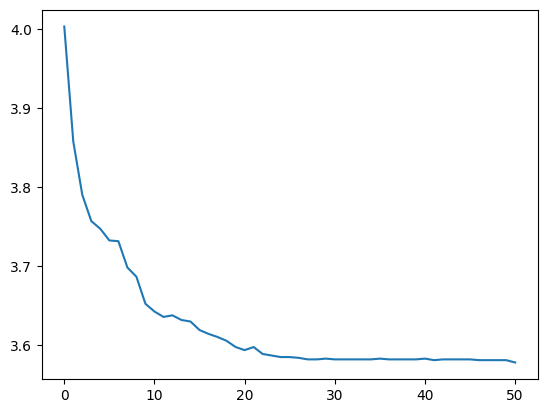

In [38]:
loss_values = [
    4.0029296875, 3.857421875, 3.7900390625, 3.7568359375, 3.7470703125, 3.732421875, 
    3.7314453125, 3.6982421875, 3.6865234375, 3.65234375, 3.642578125, 3.6357421875, 
    3.6376953125, 3.6318359375, 3.6298828125, 3.619140625, 3.6142578125, 3.6103515625, 
    3.60546875, 3.59765625, 3.59375, 3.59765625, 3.5888671875, 3.5869140625, 3.5849609375, 
    3.5849609375, 3.583984375, 3.58203125, 3.58203125, 3.5830078125, 3.58203125, 3.58203125, 
    3.58203125, 3.58203125, 3.58203125, 3.5830078125, 3.58203125, 3.58203125, 3.58203125, 
    3.58203125, 3.5830078125, 3.5810546875, 3.58203125, 3.58203125, 3.58203125, 3.58203125, 
    3.5810546875, 3.5810546875, 3.5810546875, 3.5810546875, 3.578125
]

plt.plot(loss_values)